In [104]:
using Printf
import Random
import StatsBase
import LsqFit
import PyPlot

In [105]:
function first_return(δ,τ)
    t = 0
    h = 0
    
    while true
        t = t + τ
        step_right = Random.bitrand(1)[1]
        
        if step_right
            h = h + δ
        else
            h = h - δ
        end
        
        h ≈ 0 && break
        
        # Break if random walk is taking too long. When simulating millions of random walks
        # you get quite a few extremely long walks that slow things down. We don't need them
        # to estimate \nu anyways.
        t/τ > 1e6 && break
    end
    return t
end

first_return (generic function with 1 method)

In [115]:
δ = 1
τ = 1
return_times = [first_return(δ,τ) for i = 1:1000000]

1000000-element Array{Int64,1}:
    6
 1226
   18
    2
   46
    2
   40
    2
    2
    2
    2
    8
    4
    ⋮
    4
    2
   18
    2
    4
    2
   10
    2
    2
   10
    4
    2

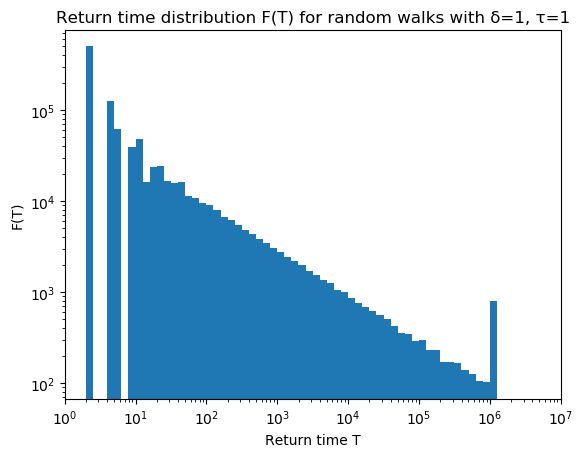

In [118]:
# Plotting a histogram from 1 to 10^6 to see what it looks like. The logarithmic bins are
# pretty coarse here.
bins = exp10.(range(0, stop=7, step=0.1));

counts, return_times_binned = PyPlot.plt[:hist](return_times, bins=bins, histtype="stepfilled");

PyPlot.xscale("log");
PyPlot.yscale("log");
PyPlot.xlim([1, 1e7]);
PyPlot.title("Return time distribution F(T) for random walks with δ=1, τ=1");
PyPlot.xlabel("Return time T");
PyPlot.ylabel("F(T)");

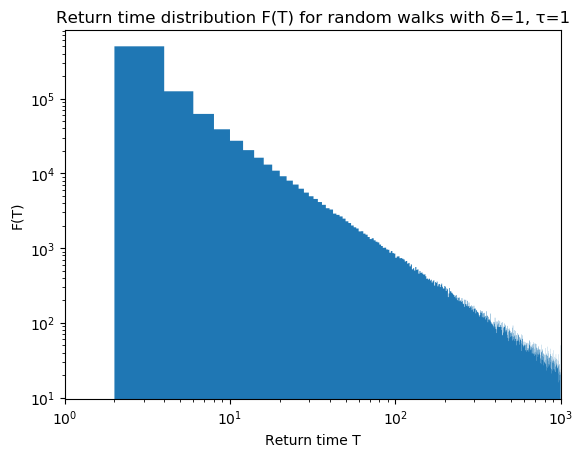

In [131]:
# To estimate ν I will just plot the frequencies from 2 to 1000 where I have better
# statistics and I can actually use bins of width 2 everywhere.

# bins = exp10.(range(0, stop=3, step=0.01));
bins = 2:2:1000

counts, return_times_binned = PyPlot.plt[:hist](return_times, bins=bins, histtype="stepfilled");

PyPlot.xscale("log");
PyPlot.yscale("log");
PyPlot.xlim([1, 1000]);
PyPlot.title("Return time distribution F(T) for random walks with δ=1, τ=1");
PyPlot.xlabel("Return time T");
PyPlot.ylabel("F(T)");

In [132]:
# Remove bins with zero entries.
nonzero_entry_indices = counts .≠ 0
counts = counts[nonzero_entry_indices]
return_times_binned = convert.(Float64, return_times_binned[1:end-1])
return_times_binned = return_times_binned[nonzero_entry_indices]

499-element Array{Float64,1}:
   2.0
   4.0
   6.0
   8.0
  10.0
  12.0
  14.0
  16.0
  18.0
  20.0
  22.0
  24.0
  26.0
   ⋮  
 976.0
 978.0
 980.0
 982.0
 984.0
 986.0
 988.0
 990.0
 992.0
 994.0
 996.0
 998.0

In [133]:
# Least squares fit to the histogram data to estimate ν.
model(x, p) = x.*(p[1]/2)
p0 = [3.0]

power_law_fit = LsqFit.curve_fit(model, log10.(counts), log10.(convert.(Float64, return_times_binned)), p0)

ν = power_law_fit.param[1];
std_err = LsqFit.standard_error(power_law_fit)[1];
margin_of_err = LsqFit.margin_error(power_law_fit, 0.05)[1];
conf_int = LsqFit.confidence_interval(power_law_fit, 0.05)[1];

@printf("Fitting F(T) ~ T^(-ν/2)\n");
@printf("Best fit to ν:       %g\n", ν);
@printf("Standard error:      %g\n", std_err);
@printf("Margin of error:     %g @ 95%%\n", margin_of_err);
@printf("Confidence interval: (%g, %g) @ 95%%\n", conf_int[1], conf_int[2]);

Fitting F(T) ~ T^(-ν/2)
Best fit to ν:       2.16375
Standard error:      0.0489761
Margin of error:     0.0962253 @ 95%
Confidence interval: (2.06752, 2.25997) @ 95%


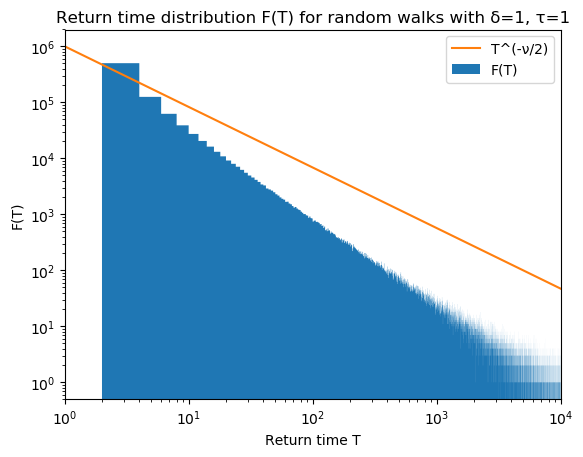

In [134]:
bins = 2:2:10000

counts, return_times_binned = PyPlot.plt[:hist](return_times, bins=bins, histtype="stepfilled", label="F(T)");
PyPlot.loglog(1:10000, [maximum(2*counts)*(T^(-ν/2)) for T=1:10000], label="T^(-ν/2)")

PyPlot.xscale("log");
PyPlot.yscale("log");
PyPlot.xlim([1, 10000]);
PyPlot.title("Return time distribution F(T) for random walks with δ=1, τ=1");
PyPlot.xlabel("Return time T");
PyPlot.ylabel("F(T)");
PyPlot.legend();